# **15. Algoritmo QAOA**

# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

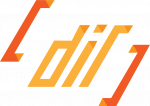

In [ ]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 61.5 MB/s eta 0:00:00


# **Introducción**

El Algoritmo QAOA (Quantum Approximate Optimization Algorithm) es un método ampliamente estudiado para resolver problemas de optimización combinatoria en dispositivos NISQ. Sus aplicaciones son amplias y de gran alcance, y su rendimiento es de gran interés para la comunidad investigadora de la computación cuántica.

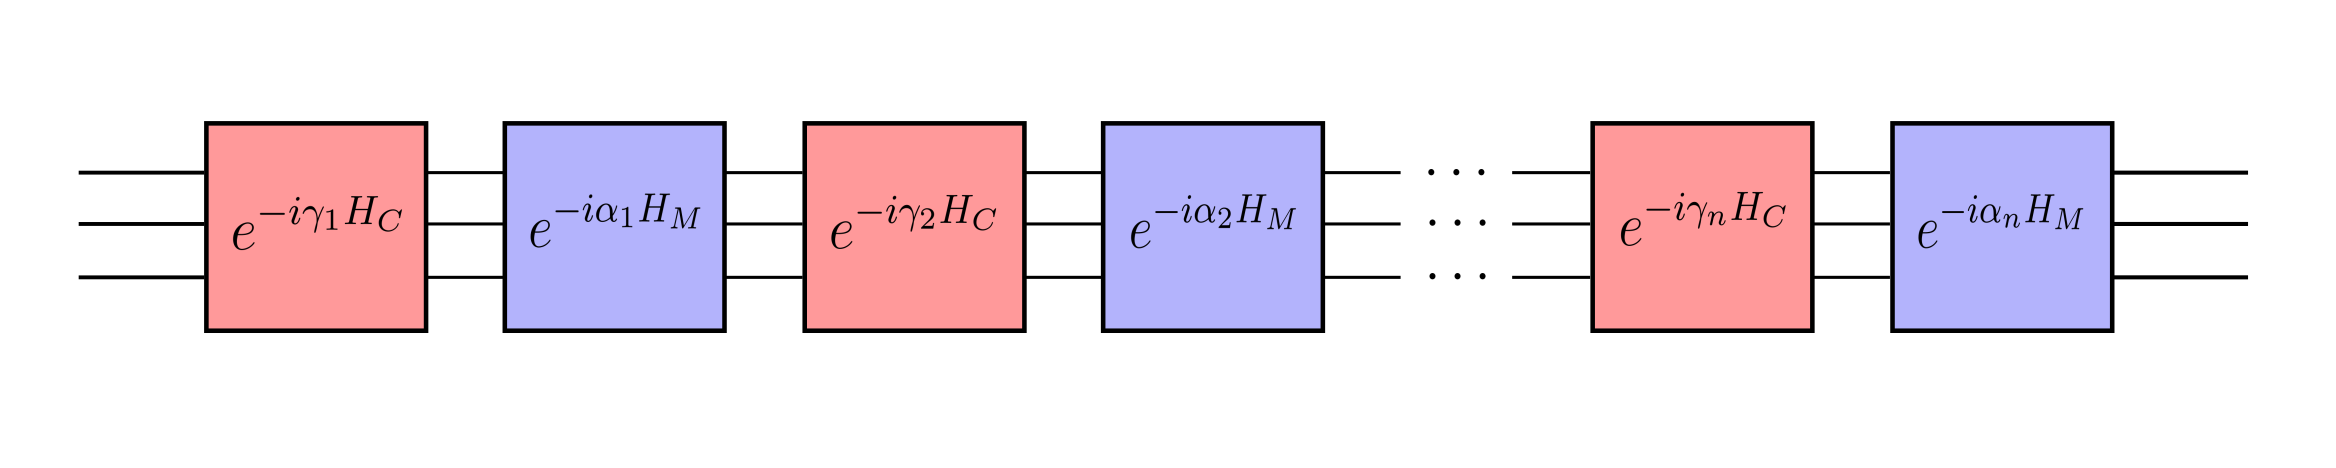

El objetivo de esta sesión es presentar los conceptos básicos de QAOA y guiarlos a través de su funcionalidad integrada en PennyLane. Aprenderemos a usar la evolución temporal para establecer una conexión entre los Hamiltonianos y los circuitos cuánticos, y a superponer estos circuitos para crear algoritmos más potentes. Estos sencillos ingredientes, junto con la capacidad de optimizar circuitos cuánticos, son los pilares de QAOA. Al centrarse en los fundamentos, PennyLane ofrece capacidades generales y flexibles que pueden personalizarse y refinarse para implementar QAOA en una amplia variedad de problemas. En la última parte de la sesión de hoy, aprenderemos a integrar estas piezas e implementar un flujo de trabajo QAOA completo para resolver el problema de cobertura mínima de vértices.

# **Circuitos y Hamiltonianos**

Al considerar circuitos cuánticos, suele ser conveniente definirlos mediante una serie de compuertas cuánticas. Sin embargo, en muchos casos resulta útil pensar en un circuito cuántico en términos de un Hamiltoniano. De hecho, las compuertas se implementan físicamente mediante la evolución temporal bajo un Hamiltoniano cuidadosamente diseñado. Estas transformaciones se describen mediante el operador de evolución temporal, que es unitario y se define como:

$$U(H, \ t) \ = \ e^{-i H t / \hbar}.$$


-----

El operador de evolución temporal se determina completamente en términos de un Hamiltoniano $H$ y un escalar $t$ que representa el tiempo. De hecho, cualquier $U$ unitario puede escribirse en la forma,

$$e^{i \gamma H}$$

donde $\gamma$ es un escalar y $H$ es un operador hermitiano ($H=H^{\dagger}$), interpretado como un Hamiltoniano. Por lo tanto, la evolución temporal establece una conexión que permite describir los circuitos cuánticos en términos de Hamiltonianos.


--------
--------

En general, implementar un circuito cuántico que exponencie un Hamiltoniano con muchos términos no conmutativos, es decir, un Hamiltoniano de la forma:

$$H \ = \ H_1 \ + \ H_2 \ + \ H_3 \ + \ \cdots \ + \ H_N,$$

es muy complejo. En su lugar, podemos usar la fórmula de descomposición de [Trotter-Suzuki](https://en.wikipedia.org/wiki/Lie_product_formula)

$$e^{A \ + \ B} \ \approx \ \Big(e^{A/n} e^{B/n}\Big)^{n},$$

para implementar una ecuación unitaria de evolución temporal *aproximada:*

$$U(H, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n}
\displaystyle\prod_{k} e^{-i H_k t / n} \ \ \ \ \ \ \ \ \ \ H \
= \ \displaystyle\sum_{k} H_k,$$

donde $U$ se aproxima a $e^{-i H t}$ a medida que $n$ aumenta.

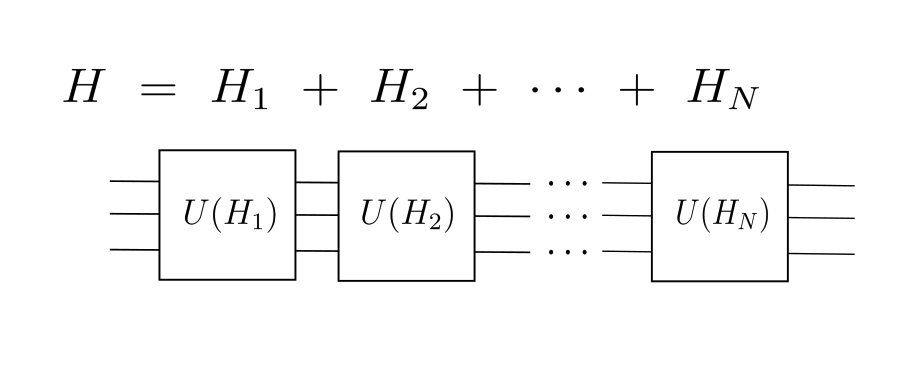


En PennyLane, esto se implementa mediante el comando `ApproachTimeEvolution()`. Por ejemplo, supongamos que tenemos el siguiente Hamiltoniano:

In [ ]:
import pennylane as qml
import warnings
warnings.filterwarnings("ignore")

In [ ]:
H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


$$H=X_{0}+Z_{1}+\frac{1}{2}X_{0}X_{1}$$

Podemos implementar el operador de evolución temporal aproximado correspondiente a este Hamiltoniano de la siguiente manera:

In [ ]:
# Definir el circuito (o dispositivo) cuántico
dev = qml.device("default.qubit", wires=2)

# Parámetros de evolución
t = 1
n = 2

# Definir el circuito cuántico
@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# Expandir el circuito para ver las compuertas reales aplicadas
expanded_circuit = qml.transforms.decompose(circuit)
print(qml.draw(expanded_circuit)())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


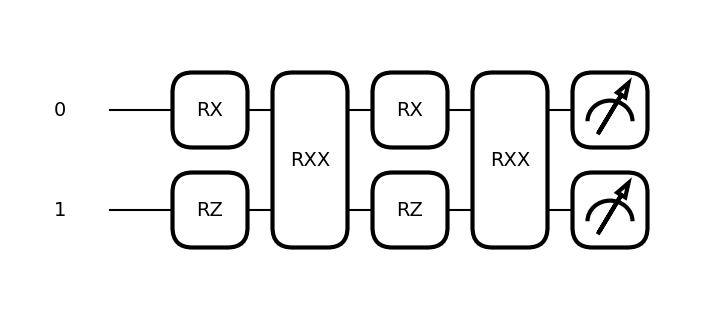

In [ ]:
import matplotlib.pyplot as plt

# Dibujar el circuito expandido
fig, ax = qml.draw_mpl(expanded_circuit)()
plt.show()

$\textbf{Análisis de las compuertas}$

-  Compuerta $RX(1.00)$ en el qubit $0$

$$RX(\theta)=e^{-i\frac{\theta}{2}X}$$

Esta es una **rotación en torno al eje $X$ del qubit $0$** con ángulo
$1.00$. Proviene del término $X_{0}$ en el Hamiltoniano.

-  Compuerta $RZ(1.00)$ en el qubit $1$

$$RZ(\theta)=e^{-i\frac{\theta}{2}Z}$$

Esta es una **rotación en torno al eje $Z$ del qubit $1$** con ángulo
$1.00$. Proviene del término $Z_{1}$ en el Hamiltoniano.

-  Compuerta $RXX(0.50)$ (Interacción entre los qubits $0$ y $1$)

$$RXX(\theta)=e^{-i\frac{\theta}{2}X\otimes X}$$

Esto implementa una interacción cuántica entre los qubits $0$ y $1$ con coeficiente $0.50$. Proviene del término $0.5X_{0}X_{1}$ en el Hamiltoniano.

- Se repite la secuencia (por que $n=2$)

La evolución trotterizada con $n=2$ hace que este bloque de operaciones se repita dos veces.

--------
--------

# **Circuitos en capas**

Piensa en todas las veces que has copiado un texto o una imagen y luego lo has pegado repetidamente, creando muchos duplicados. ¡Esta también es una característica útil al diseñar algoritmos cuánticos! **La idea de repetición es omnipresente en la computación cuántica: desde la amplificación de amplitud en el algoritmo de Grover hasta las capas en las redes neuronales cuánticas y la simulación Hamiltoniana**, la aplicación repetida de un circuito es una herramienta fundamental en los algoritmos cuánticos.

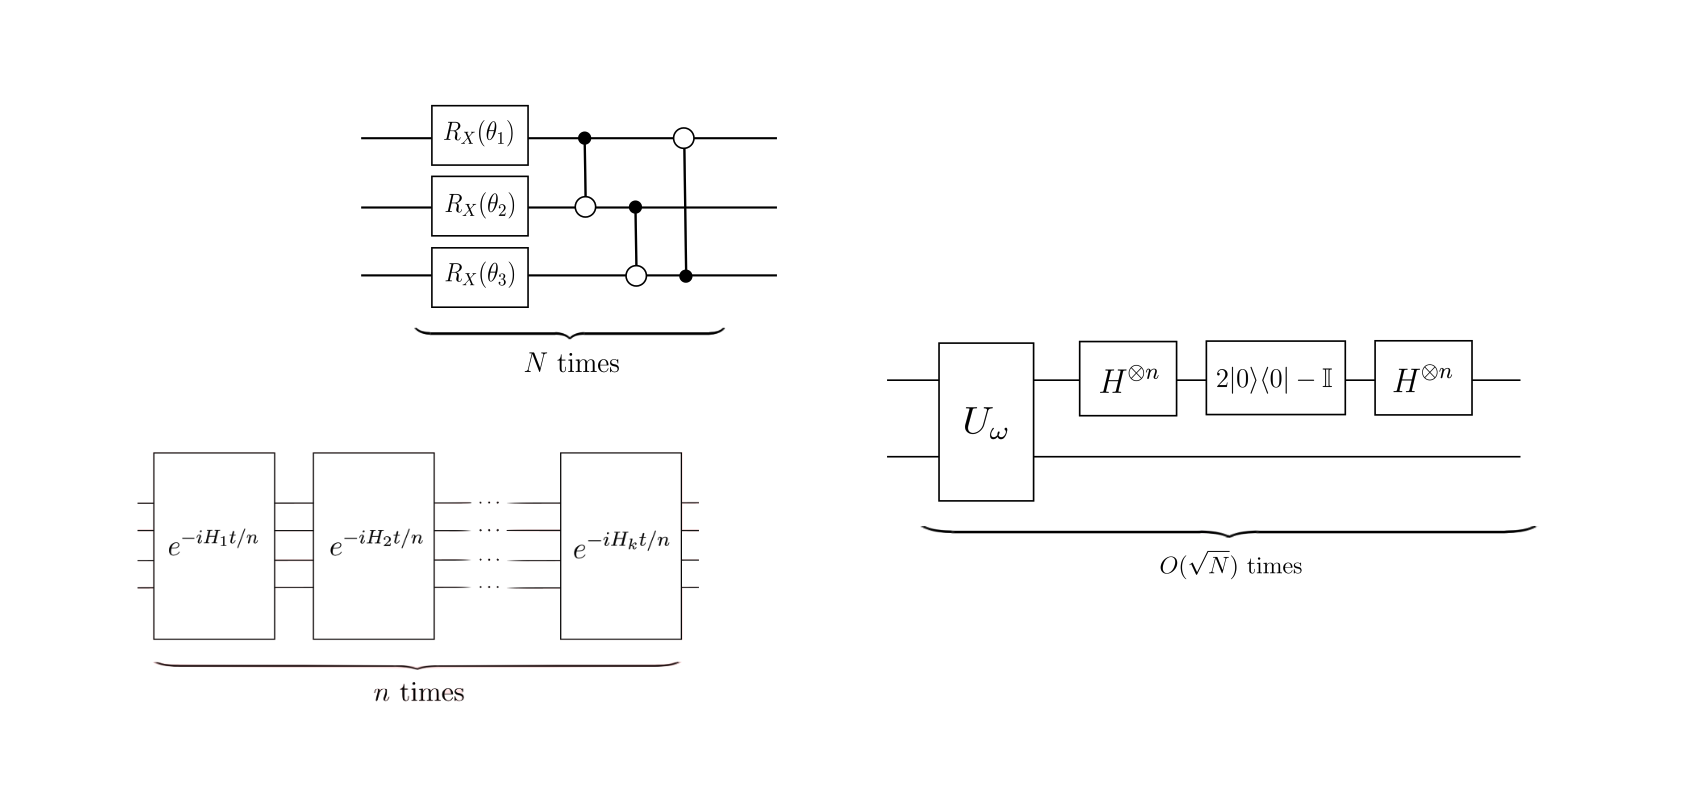


--------


**La repetición de circuitos se implementa en PennyLane mediante el comando** `layer()`. Este método permite tomar una función que contenga operaciones cuánticas, una plantilla o incluso una sola compuerta cuántica y aplicarla repetidamente a un conjunto de **cables** (wires).

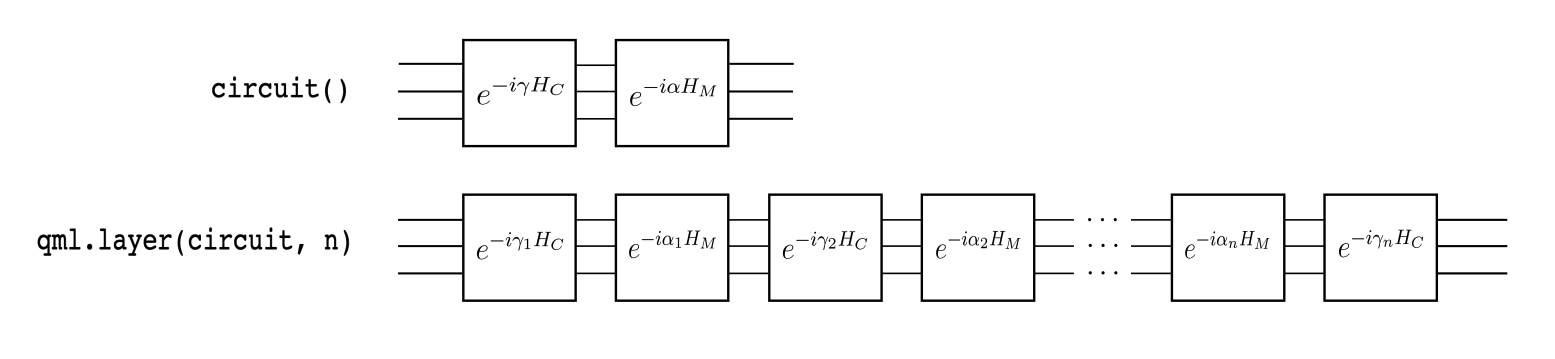

Para crear un circuito más grande con muchas repeticiones, pasamos el circuito que se va a repetir como argumento y especificamos el número de repeticiones. Por ejemplo, supongamos que queremos superponer el siguiente circuito tres veces:

In [ ]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

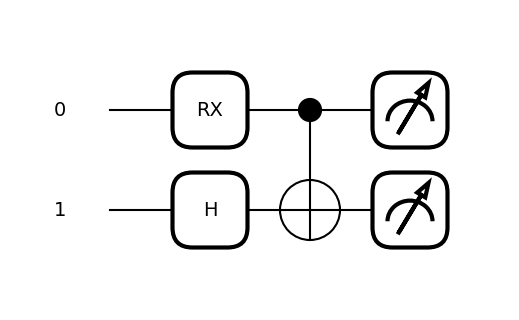

In [ ]:
# Dibujar el circuito con Matplotlib
fig, ax = qml.draw_mpl(circuit)([0.5])  # Pasamos el parámetro como una lista
plt.show()

In [ ]:
import numpy as np

In [ ]:
@qml.qnode(dev)
def state_vector(theta):
    circ(theta)
    return qml.state()

theta_val = 0.5
state = state_vector(theta_val)

# Estados base
basis = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']

# Mostrar amplitudes en notación de Dirac
print("Estado final en notación de Dirac:\n")
for amp, label in zip(state, basis):
    amp_real = np.real(amp)
    amp_imag = np.imag(amp)
    if np.abs(amp) > 1e-10:  # Ignora términos ~0
        print(f"({amp_real:.3f} + {amp_imag:.3f}j) {label}")

Estado final en notación de Dirac:

(0.685 + 0.000j) |00⟩
(0.685 + 0.000j) |01⟩
(0.000 + -0.175j) |10⟩
(0.000 + -0.175j) |11⟩


Simplemente pasamos esta función a `layer()`:

In [ ]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


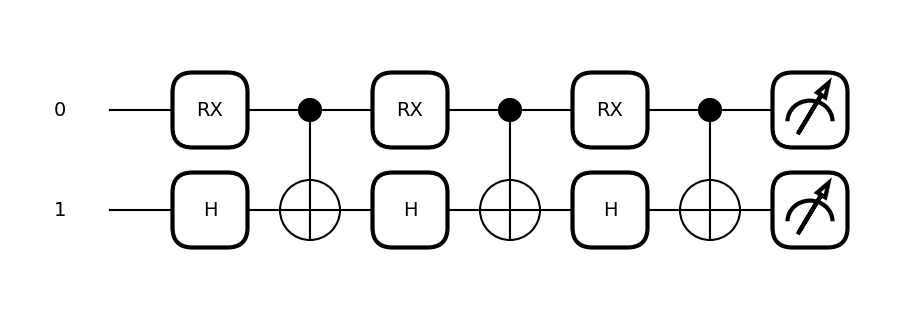

In [ ]:
fig, ax = qml.draw_mpl(circuit)([0.3, 0.4, 0.5])  # Pasamos la lista de parámetros correctamente
plt.show()

 Hasta aquí hemos aprendido cómo se puede usar la evolución temporal para crear circuitos a partir de Hamiltonianos, y cómo estos se pueden superponer para crear circuitos más largos. Ahora estamos listos para explorar el QAOA.

--------
--------

# **QAOA**

El algoritmo de optimización cuántica aproximada (QAOA) es una técnica general que permite encontrar soluciones aproximadas a problemas de optimización combinatoria, en particular problemas que pueden formularse como la búsqueda de una cadena de bits óptima. QAOA consta de los siguientes pasos:

**1.** Definir un Hamiltoniano de coste $H_C$ tal que su estado fundamental (estado base) codifique la solución del problema de optimización.

**2.** Definir un Hamiltoniano de mezclador $H_M$.

**3.** Construir los circuitos $e^{-i \gamma H_C}$ y $e^{-i\alpha H_M}$. Estos se denominan capas de coste y de mezclador.

**4.** Elija un parámetro $n \ge 1$ y construya el circuito:

$$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$
que consiste en la aplicación repetida de las capas de coste y mezclador.

**5.** Prepare un estado inicial, aplique $U(\alpha, \gamma)$ y utilice técnicas clásicas para optimizar los parámetros.

**6.** Una vez optimizado el circuito, las mediciones del estado de salida revelan soluciones aproximadas al problema de optimización.

En resumen, el punto de partida de QAOA es la especificación de los Hamiltonianos de coste y mezclador. A continuación, utilizamos la evolución temporal y la estratificación para crear un circuito variacional y optimizar sus parámetros. El algoritmo concluye con un muestreo del circuito para obtener una solución aproximada al problema de optimización. ¡Veámoslo en acción!



# **El problema del Minimum Vertex Cover**

Nuestro objetivo es encontrar la cobertura mínima de vértices de un grafo: un conjunto de vértices tal que cada arista del grafo contiene al menos uno de los vértices de la cobertura. Por lo tanto, estos vértices **"cubren"** todas las aristas. Queremos encontrar la cobertura de vértices con el menor número posible de vértices.

Las coberturas de vértices se pueden representar mediante una **cadena de bits** donde cada bit indica si el vértice correspondiente está presente en la cobertura. Por ejemplo, la cadena de bits $01010$ representa una cobertura compuesta por el segundo y el cuarto vértice en un grafo con cinco vértices.

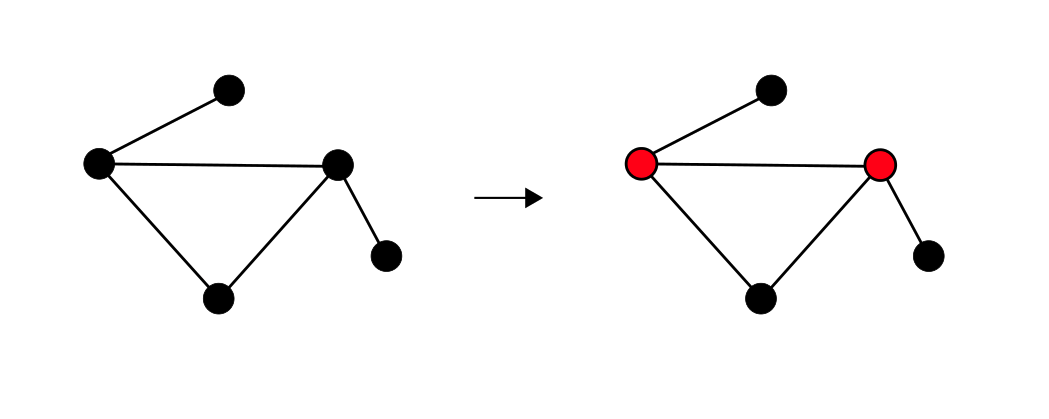

$\textbf{Para implementar QAOA con PennyLane, primero importamos las dependencias necesarias:}$

In [ ]:
from pennylane import qaoa
from pennylane import numpy as np
import networkx as nx

También definimos el grafo de cuatro vértices para el cual queremos encontrar la cobertura mínima de vértices:

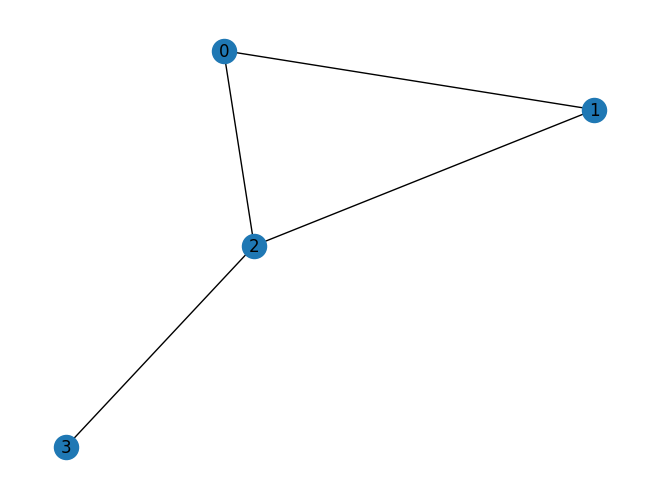

In [ ]:
edges = [(0,1), (1,2), (2,0), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

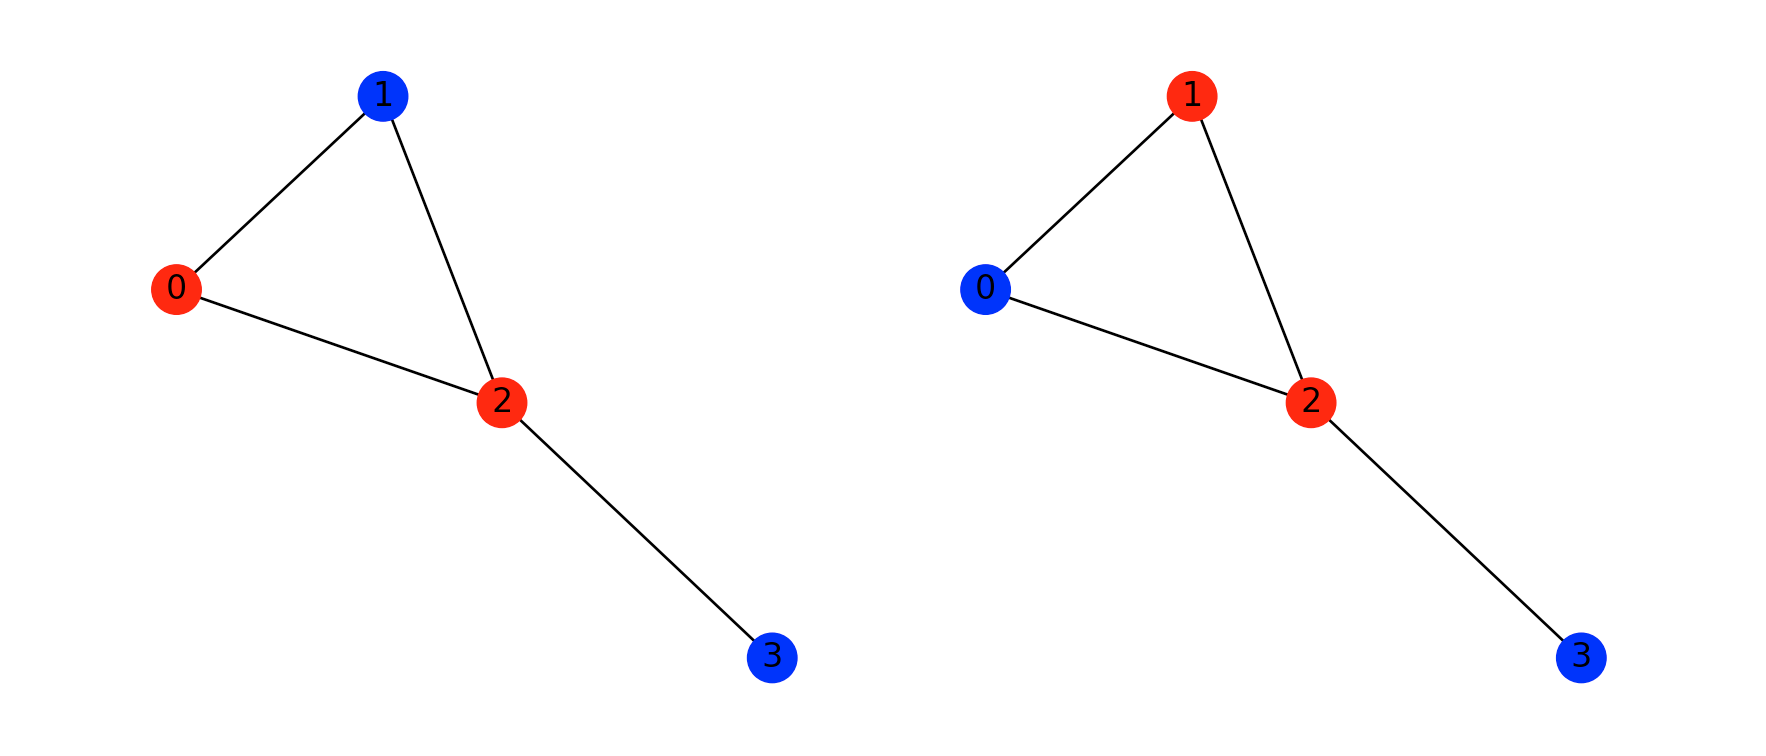

Los estados $|1010⟩$ y $|0110⟩$ tienen las mayores probabilidades de ser medidos.

**Este grafo tiene dos coberturas mínimas de vértices:** los vértices $0$ y $2$, y los vértices $1$ y $2$. Estos se representan respectivamente mediante las cadenas de bits $1010$ y $0110$. El objetivo del algoritmo es muestrear estas cadenas de bits con alta probabilidad.

El comando `qaoa` de PennyLane incorpora una colección de problemas de optimización, incluyendo la **cobertura mínima de vértices**. Para cada problema, se puede obtener el Hamiltoniano de coste, así como un Hamiltoniano mezclador recomendado. Esto facilita la obtención de Hamiltonianos para problemas específicos, a la vez que permite la flexibilidad de tomar otras decisiones, por ejemplo, añadir restricciones o experimentar con diferentes mezcladores.

En nuestro caso, el Hamiltoniano de coste tiene dos estados fundamentales, $\vert 1010\rangle$ y $\vert 0110\rangle$, que coinciden con las soluciones del problema. El Hamiltoniano mezclador es la suma simple, no conmutativa, de las operaciones de Pauli-$X$ en cada nodo del grafo:

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


$$
H_C = 0.75 \sum_{i,j} Z_i Z_j + 0.75 \sum_{i} Z_i - \sum_{i} Z_i
$$

Expandiendo los términos específicos del grafo:

$$
H_C = 0.75 (Z_0 Z_1 + Z_0 + Z_1) + 0.75 (Z_0 Z_2 + Z_0 + Z_2) + 0.75 (Z_1 Z_2 + Z_1 + Z_2) + 0.75 (Z_2 Z_3 + Z_2 + Z_3) - (Z_0 + Z_1 + Z_2 + Z_3)
$$

El Hamiltoniano mezclador:

$$
H_M = \sum_{i} X_i
$$

Expandiendo para cada nodo:

$$
H_M = X_0 + X_1 + X_2 + X_3
$$


Una sola capa de QAOA consiste en la evolución temporal bajo estos Hamiltonianos:

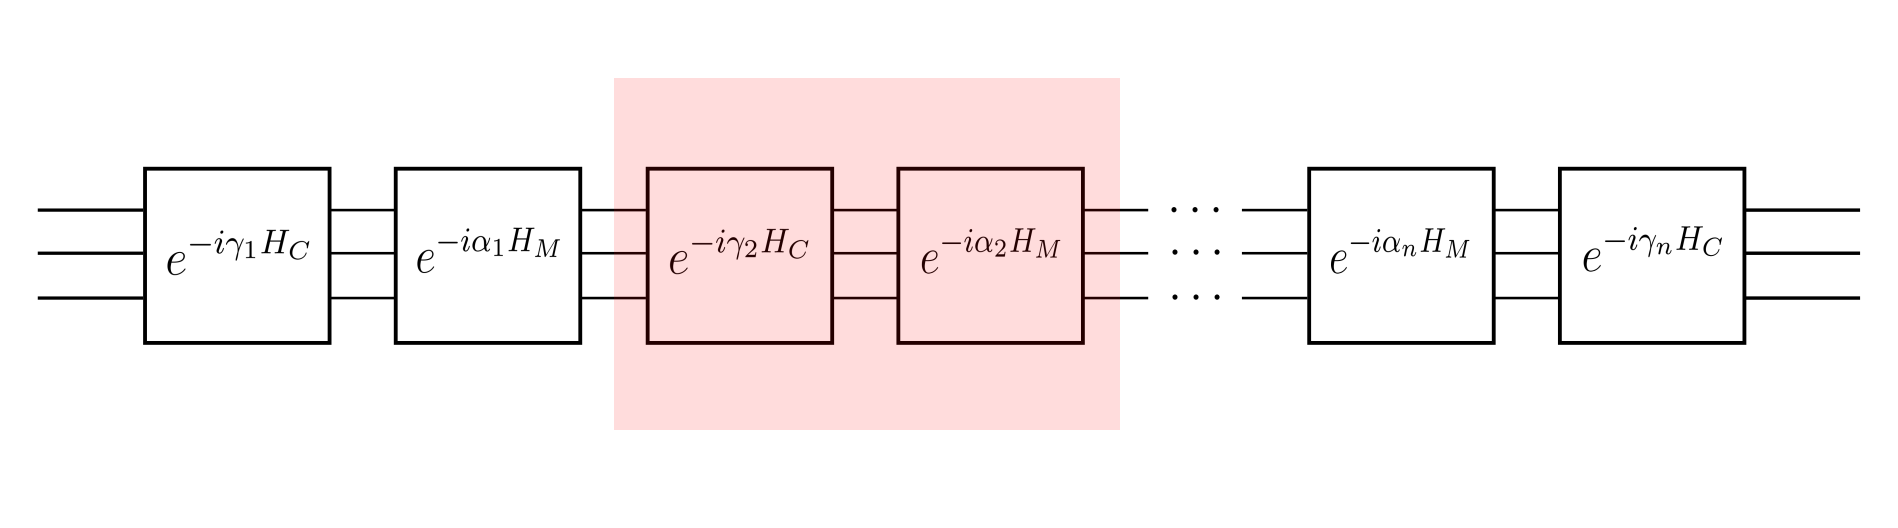

Si bien es posible usar `ApproachTimeEvolution()`, el comando `qaoa` permite construir las capas de coste y mezclador directamente mediante las funciones `cost_layer()` y `mixer_layer()`, que toman como entrada los respectivos Hamiltonianos y los parámetros variacionales:

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

Ahora estamos listos para construir el circuito variacional completo. El número de cables es igual al número de vértices del grafo. Inicializamos el estado con una superposición par sobre todos los estados base. Para este ejemplo, empleamos un circuito compuesto por dos capas QAOA:

In [ ]:
wires = range(4) # 4 qubits (uno por cada nodo del grafo)
depth = 2 # Número de capas QAOA

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)  # Inicializa cada qubit en superposición
    qml.layer(qaoa_layer, depth, params[0], params[1])

Tenga en cuenta que `layer()` nos permite pasar los parámetros variacionales `params[0]` y `params[1]` a cada capa del circuito. El último paso es la especialidad de PennyLane: **optimizar los parámetros del circuito**.

La función de coste es el valor esperado de $H_C$, que queremos minimizar. Usamos la función `expval()`, que devuelve el valor esperado del Hamiltoniano con respecto al estado de salida del circuito. También definimos el dispositivo en el que se realiza la simulación. Usamos el complemento **PennyLane-Qulacs** para ejecutar el circuito en el simulador Qulacs:

In [ ]:
!pip install pennylane-qulacs["cpu"] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 11.4 MB/s eta 0:00:00


In [ ]:
dev = qml.device("qulacs.simulator", wires=wires) # Definición del dispositivo cuántico

@qml.qnode(dev)
def cost_function(params):    # Definición de la función de coste
    circuit(params)
    return qml.expval(cost_h) # Mide el valor esperado del Hamiltoniano de coste

Finalmente, optimizamos la función de coste mediante la función integrada `GradientDescentOptimizer()`. **Optimizamos setenta pasos e inicializamos los parámetros**.

In [ ]:
# optimizador de descenso de gradiente
optimizer = qml.GradientDescentOptimizer()
# bucle de iteraciones
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True) # parámetros de QAOA

Observe que establecimos cada parámetro inicial en $0,5$. Para fines de demostración, elegimos parámetros iniciales que sabemos que funcionan bastante bien y que no se atascan en ningún mínimo local.

La elección de los parámetros iniciales para un circuito variacional suele ser un problema difícil, por lo que no nos extenderemos demasiado en esta sesión. Sin embargo, es importante tener en cuenta que encontrar un conjunto inicial de parámetros que funcione bien para algunos problemas de juguete suele producir buenos resultados también para instancias más complejas del algoritmo.

Ahora podemos optimizar el circuito:

In [ ]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

In [ ]:
from sympy import Matrix, latex
from IPython.display import display, Math

params_matrix = Matrix(params)
display(Math(r"\mathbf{\theta} = " + latex(params_matrix)))

<IPython.core.display.Math object>

Con los parámetros óptimos, podemos reconstruir el panorama de probabilidades. Redefinimos el circuito QAOA completo con los parámetros óptimos, pero esta vez devolvemos las probabilidades de medir cada **cadena de bits**:

In [ ]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

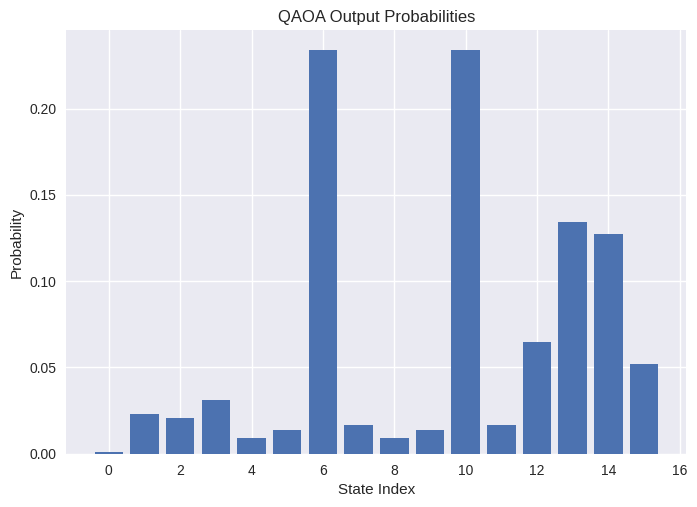

In [ ]:
# Usar un estilo válido
plt.style.use("seaborn-v0_8")

# Graficar las probabilidades
plt.bar(range(2 ** len(wires)), probs)
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.title("QAOA Output Probabilities")
plt.show()

Los estados $|6⟩ = |0110⟩$ y $|10⟩ = |1010⟩$ tienen las mayores probabilidades de ser medidos, ¡tal como se esperaba!

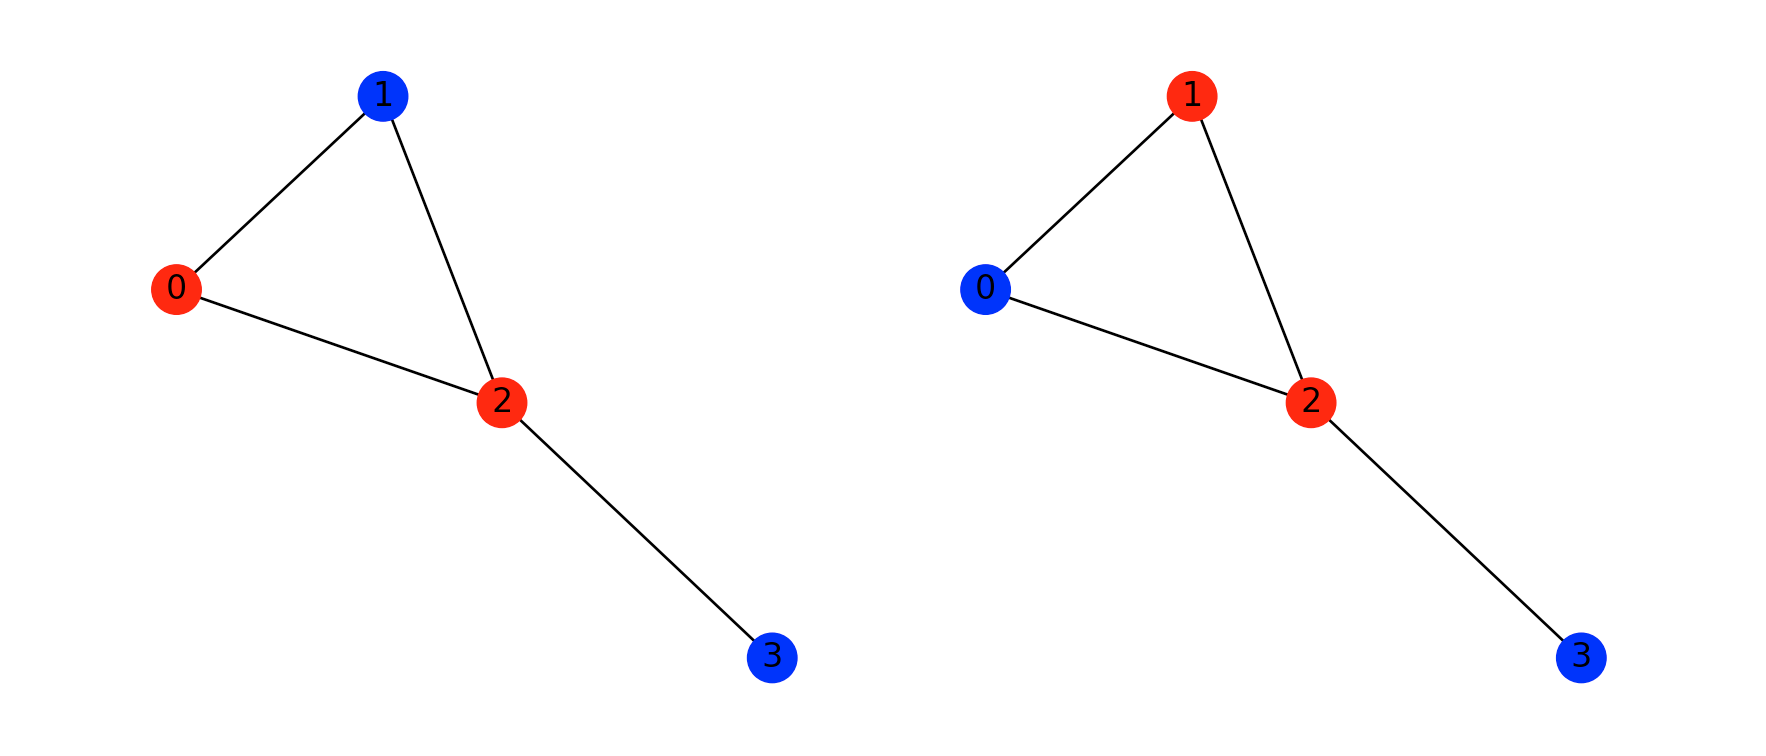

--------
--------

# **Customización del QAOA**

**QAOA no es una solución universal para problemas de optimización**. En muchos casos, los Hamiltonianos de coste y mezclador serán muy específicos de un escenario y no necesariamente encajarán en la estructura de los problemas predefinidos en el comando `qaoa()`. Afortunadamente, uno de los principios fundamentales de toda la biblioteca PennyLane es la customización, ¡y este principio también se aplica al comando QAOA!

El flujo de trabajo de QAOA descrito anteriormente nos proporcionó dos soluciones óptimas: $|6⟩=|0110⟩$ y $|10⟩=|1010⟩$. ¿Qué sucedería si añadiéramos una restricción que hiciera que una de estas soluciones fuera **"mejor"** que la otra? Imaginemos que nos interesan soluciones que minimizan la función de coste original, pero que también colorean el primer y el tercer vértice con $1$. Una restricción de esta forma favorecerá a $|10⟩$, convirtiéndolo en el único estado fundamental verdadero.

Es fácil introducir restricciones de esta forma en PennyLane. Podemos usar el Hamiltoniano de coste `edge_driver()` para **"premiar"** los casos en los que el primer y el último vértice del grafo son $0$:


In [ ]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ['11'])

A continuación, ponderamos y añadimos el término restrictivo al Hamiltoniano original de cobertura mínima de vértices:

In [ ]:
new_cost_h = cost_h + 2*reward_h

Tengamos en cuenta que PennyLane permite la suma y multiplicación simple de objetos Hamiltonianos mediante operaciones aritméticas en línea ➕ ➖ ✖️➗. Finalmente, podemos usar este nuevo hamiltoniano de coste para definir un nuevo flujo de trabajo en QAOA:

In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


In [ ]:
params_matrix = Matrix(params)
display(Math(r"\mathbf{\theta} = " + latex(params_matrix)))

<IPython.core.display.Math object>

A continuación, reconstruimos el paisaje de probabilidades con los parámetros óptimos:

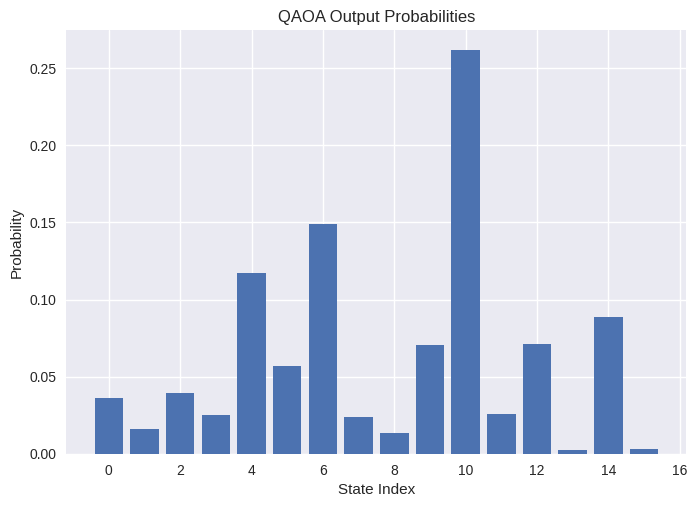

In [ ]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

# Ejecutar el circuito para obtener probabilidades
probs = np.array(probability_circuit(params[0], params[1]))  # Asegurar que es un array NumPy

# Establecer el estilo corregido
plt.style.use("seaborn-v0_8")  # O usar "ggplot" si hay problemas

# Graficar las probabilidades
plt.bar(range(2 ** len(wires)), probs)
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.title("QAOA Output Probabilities")

# Mostrar el gráfico
plt.show()

Tal como lo esperábamos, el estado $\vert 10⟩$ ahora es favorecido sobre $\vert 6\rangle$!